In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the census information pulled in RetrievingCensusData.ipynb file.

census_df = pd.read_csv("~/Desktop/CensusData.csv")

In [3]:
# Dropping unnecessary columns.

census_df = census_df.drop(["Unnamed: 0","Per Capita Income","Name"],axis=1)

In [4]:
# Extracting the census data only for the zipcodes in the city of Austin. 

austin_zipcodes = [78741,78753,78701,78758,78704,78702,78745,78744,78723,78752,78748,78751,78759,78757,78705,78721,
                   78724,78749,78703,78727,78746,78731,78729,78750,78754,78722,78617,78756,78735,78719,78747,78717,
                   78726,78613,78660,78739,78736,78725,78742,78730,78653,78728,78652,78712,78732,78733,78737,78610,78734]
median_age = [] 
population = [] 
no_education =[] 
GED_education = []
bachelor_education = [] 
poverty_count = []
household_income = []
median_home_value = [] 
zipcode_ = []
for index,row in census_df.iterrows():
    if row["Zipcode"] in austin_zipcodes:
        median_age.append(row[0]) 
        population.append(row[1]) 
        no_education.append(row[2])
        GED_education.append(row[3])
        bachelor_education.append(row[4])
        poverty_count.append(row[5])
        household_income.append(row[6])
        median_home_value.append(row[7])
        zipcode_.append(row[8])

dictionary = {'Median Age':median_age,
              'Population':population, 
              'No Education':no_education, 
              'GED Education':GED_education,
              'Bachelor Education':bachelor_education, 
              'Poverty Count':poverty_count, 
              'Household Income':household_income,
              'Median Home Value':median_home_value, 
              'Zipcode':zipcode_}

austin_census_df = pd.DataFrame(dictionary)

In [5]:
# Since the census data contains the info between 2012 and 2016, there are 5 different rows for each zip code.
# So, we're grouping by zipcode.  

grouped_austin_census_df = austin_census_df.groupby(by="Zipcode")
grouped_austin_census_df = grouped_austin_census_df.describe()
grouped_austin_census_df = grouped_austin_census_df.reset_index()
grouped_austin_census_df["Zipcode"] = grouped_austin_census_df["Zipcode"].astype(int)

In [6]:
# Crime info comes from another csv file.

crime_df = pd.read_csv('~/Desktop/CleanedAustinCrimeReport.csv')

In [7]:
# Since the census info is available only for years between 2012 and 2016, we extract the crime data for those years 
# as well.

crime_df_2012 =crime_df[crime_df.occ_year==2012]
crime_df_2013 =crime_df[crime_df.occ_year==2013]
crime_df_2014 =crime_df[crime_df.occ_year==2014]
crime_df_2015 =crime_df[crime_df.occ_year==2015]
crime_df_2016 =crime_df[crime_df.occ_year==2016]

In [8]:
#Combining the yearly dataframes extracted above.

crime_df_1213 = pd.concat([crime_df_2012,crime_df_2013])
crime_df_1415 = pd.concat([crime_df_2014,crime_df_2015])
crime_df_1215 = pd.concat([crime_df_1213,crime_df_1415])
crime_df_1216 = pd.concat([crime_df_1215,crime_df_2016])

In [9]:
# Finding the number of crimes by zipcode.

crime_df_1216_byzipcode = pd.DataFrame(crime_df_1216["zip_code"].value_counts())
crime_df_1216_byzipcode = crime_df_1216_byzipcode.reset_index()
crime_df_1216_byzipcode = crime_df_1216_byzipcode.rename(columns={"index":"Zipcode", "zip_code":"number_of_crimes"})
crime_df_1216_byzipcode["Zipcode"] = crime_df_1216_byzipcode["Zipcode"].astype(int)
crime_df_1216_byzipcode.head()

,Zipcode,number_of_crimes
0,78741,49132
1,78753,43812
2,78701,38242
3,78758,37428
4,78704,35642


In [10]:
# Combining census and crime related dataframes.

combined_df = pd.merge(grouped_austin_census_df,crime_df_1216_byzipcode, how="left", on="Zipcode")
combined_df = combined_df.fillna(0)
combined_df = combined_df.loc[combined_df['Household Income','min']>0,:]

In [11]:
# Add in Poverty Rate (Poverty Count / Population) and Crime Rate (Number of Crimes / Population)
combined_df["Poverty Rate"] = 100 * combined_df["Poverty Count","mean"]/ combined_df["Population","mean"]
combined_df["num_of_cri_pop_ratio"] = 100 * combined_df["number_of_crimes"]/ combined_df["Population","mean"]
combined_df = combined_df[combined_df.num_of_cri_pop_ratio<100]

In [12]:
# Finding the R value for Number of Crimes vs. Poverty Rate (%) per ZipCode graph.  

from scipy.stats import linregress

(slope, intercept, r_value,p_value, _) = linregress(combined_df["Poverty Rate"],combined_df["number_of_crimes"])
fit = slope * combined_df["Poverty Rate"] + intercept
print(f"R Value = {r_value}")
# R varies between 0 and 1. The closer R gets to 1, the better fit you'll see.

R Value = 0.5804380871416973


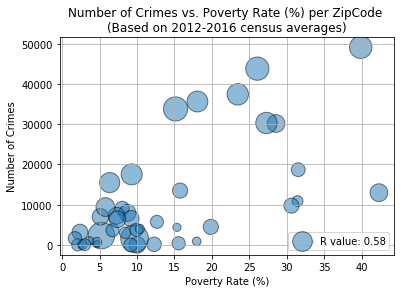

In [13]:
# Plotting Number of Crimes vs. Poverty Rate (%) per ZipCode graph.

plt.scatter(combined_df["Poverty Rate"],combined_df["number_of_crimes"],s=combined_df["Population","mean"]/100,
            edgecolor="Black",alpha = 0.5, label="R value: {}".format(round(r_value,2)))
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Number of Crimes")
plt.title("""Number of Crimes vs. Poverty Rate (%) per ZipCode 
(Based on 2012-2016 census averages)""")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("Number_of_Crimes_vs_Poverty_Rate_per_ZipCode.png",bbox_inches='tight')
plt.show()

In [14]:
# Finding the R value for Number of Crimes/Population Ratio (%) vs. Poverty Rate (%) per ZipCode graph.

(slope, intercept, r_value,p_value, _) = linregress(combined_df["Poverty Rate"],combined_df["num_of_cri_pop_ratio"])
fit = slope * combined_df["Poverty Rate"] + intercept
print(f"R Value = {r_value}")
# R varies between 0 and 1. The closer R gets to 1, the better fit you'll see.

R Value = 0.7607323197930603


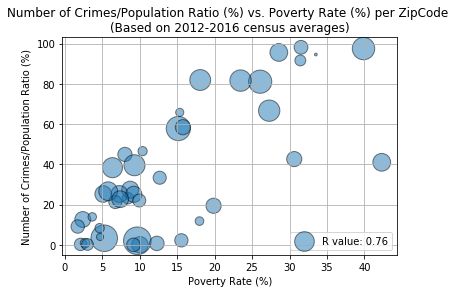

In [15]:
# Plotting Number of Crimes/Population Ratio (%) vs. Poverty Rate (%) per ZipCode graph.

plt.scatter(combined_df["Poverty Rate"],combined_df["num_of_cri_pop_ratio"],s=combined_df["Population","mean"]/100,
            edgecolor="Black",alpha = 0.5, label="R value: {}".format(round(r_value,2)))
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Number of Crimes/Population Ratio (%)")
plt.title("""Number of Crimes/Population Ratio (%) vs. Poverty Rate (%) per ZipCode 
(Based on 2012-2016 census averages)""")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("Crimes_Rate_vs_Poverty_Rate_per_ZipCode.png",bbox_inches='tight')
plt.show()

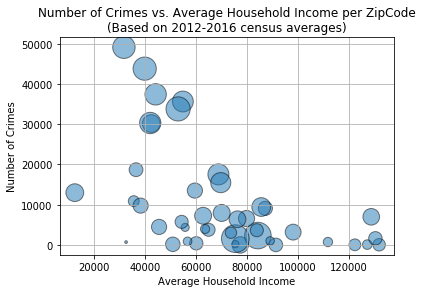

In [16]:
# Plotting Number of Crimes vs. Average Household Income per ZipCode graph.
plt.scatter(combined_df["Household Income","mean"],combined_df["number_of_crimes"],s=combined_df["Population","mean"]/100,
            edgecolor="Black",alpha = 0.5)
plt.xlabel("Average Household Income")
plt.ylabel("Number of Crimes")
plt.title("""Number of Crimes vs. Average Household Income per ZipCode
(Based on 2012-2016 census averages)""")
plt.grid()
plt.savefig("Number_of_Crimes_vs_Average_Household_Income_per_ZipCode.png",bbox_inches='tight')
plt.show()

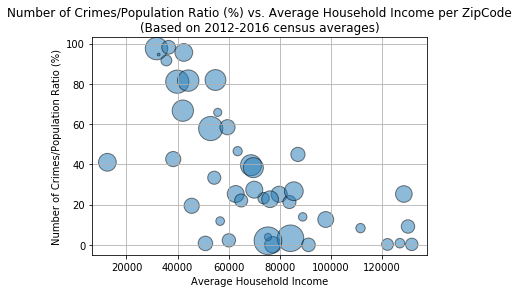

In [17]:
# Plotting Number of Crimes/Population Ratio (%) vs. Average Household Income per ZipCode graph.

plt.scatter(combined_df["Household Income","mean"],combined_df["num_of_cri_pop_ratio"],s=combined_df["Population","mean"]/100,
            edgecolor="Black",alpha = 0.5)
plt.xlabel("Average Household Income")
plt.ylabel("Number of Crimes/Population Ratio (%)")
plt.title("""Number of Crimes/Population Ratio (%) vs. Average Household Income per ZipCode
(Based on 2012-2016 census averages)""")
plt.grid()
plt.savefig("Crime_Rate_vs_Average_Household_Income_per_ZipCode.png",bbox_inches='tight')
plt.show()

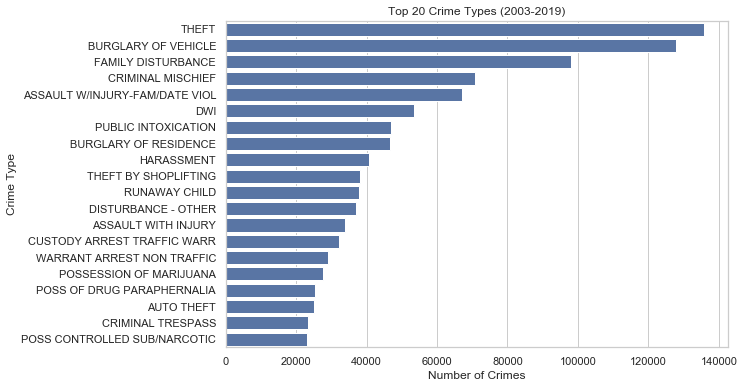

In [18]:
# Plotting Top 20 Crime Types (2003-2019) bar graph. 

import seaborn as sns

top_20_crimes = crime_df['crime_type'].value_counts().head(20)
sns.set(rc={'figure.figsize':(9,6)},style="whitegrid")
fig = sns.barplot(y=top_20_crimes.index, x=top_20_crimes.values,color='b')
fig.set(xlabel='Number of Crimes', ylabel='Crime Type')
plt.title('Top 20 Crime Types (2003-2019)')
plt.savefig("Top_20_Crime_Types_2003_2019.png",bbox_inches='tight')
plt.show()

In [19]:
# Add in Bachelor Education Rate (Bachelor Education / Population)
combined_df["Bachelor Education Rate"] = 100 * combined_df["Bachelor Education","mean"]/ combined_df["Population","mean"]

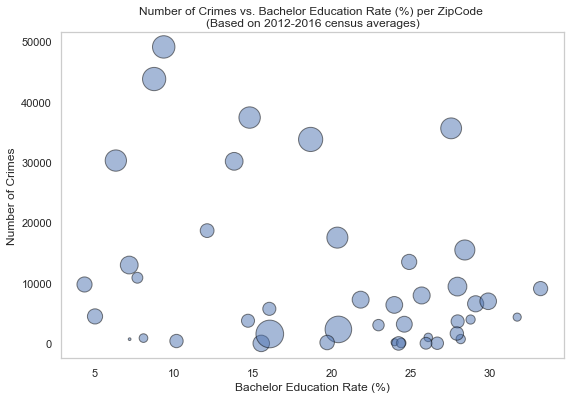

In [20]:
# Plotting Number of Crimes vs. Bachelor Education Rate (%) per ZipCode graph.

plt.scatter(combined_df["Bachelor Education Rate"],combined_df["number_of_crimes"],s=combined_df["Population","mean"]/100,
            edgecolor="Black",alpha = 0.5)
plt.xlabel("Bachelor Education Rate (%)")
plt.ylabel("Number of Crimes")
plt.title("""Number of Crimes vs. Bachelor Education Rate (%) per ZipCode 
(Based on 2012-2016 census averages)""")
plt.savefig("Number_of_Crimes_vs_Bachelor_Education_Rate_per_ZipCode.png",bbox_inches='tight')
plt.grid()
plt.show()

In [21]:
# Add in No Education/GED Rate 
combined_df["No Education/GED Rate"] = 50 * (combined_df["No Education","mean"]+combined_df["GED Education","mean"]) / combined_df["Population","mean"]

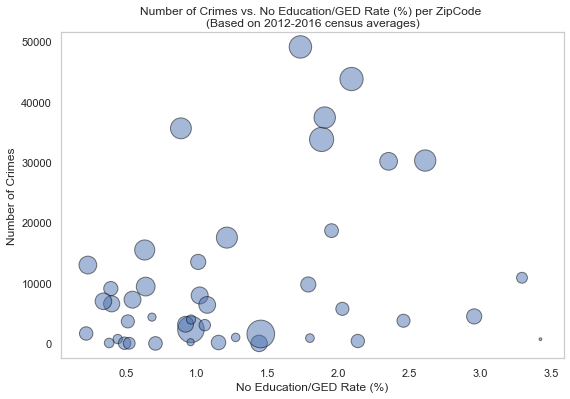

In [22]:
# Plotting Number of Crimes vs. No Education/GED Rate (%) per ZipCode graph.

plt.scatter(combined_df["No Education/GED Rate"],combined_df["number_of_crimes"],s=combined_df["Population","mean"]/100,
            edgecolor="Black",alpha = 0.5)
plt.xlabel("No Education/GED Rate (%)")
plt.ylabel("Number of Crimes")
plt.title("""Number of Crimes vs. No Education/GED Rate (%) per ZipCode 
(Based on 2012-2016 census averages)""")
plt.savefig("Number_of_Crimes_vs_No_Education_GED_Rate_per_ZipCode.png",bbox_inches='tight')
plt.grid()
plt.show()